In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import seaborn as sns
from scipy.sparse.linalg import svds
from scipy.linalg import eigh
import warnings
warnings.filterwarnings('ignore')

In [30]:
file_path = '/Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/reduced/lyrics_minimal.csv'
df = pd.read_csv(file_path)
english_df = df[df['language'] == 'en'].copy()


In [31]:
# Filtern nach englischen Texten für bessere Analyse
english_df = df[df['language'] == 'en'].copy()
print(f"Englische Texte: {english_df.shape[0]}")

# Textbereinigungsfunktion
def clean_text(text):
    if pd.isna(text):
        return ""
    # Text in Kleinbuchstaben umwandeln und Sonderzeichen entfernen
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    return text

# Texte bereinigen
english_df['cleaned_lyrics'] = english_df['lyrics'].apply(clean_text)

# Einfache Tokenisierungsfunktion (ohne NLTK-Abhängigkeit)
def simple_tokenize(text):
    if pd.isna(text):
        return []
    # Text normalisieren und in Wörter aufteilen
    words = str(text).lower().split()
    # Sonderzeichen entfernen und kurze Wörter filtern
    words = [re.sub(r'[^\w]', '', word) for word in words]
    words = [word for word in words if len(word) > 2]
    return words

# Alternative NLTK-Tokenisierungsfunktion (falls NLTK installiert ist)
def nltk_tokenize(text):
    try:
        # Versuche NLTK zu laden und zu verwenden
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        stop_words = set(stopwords.words('english'))
        
        if pd.isna(text):
            return []
        tokens = word_tokenize(str(text).lower())
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 2]
        return tokens
    except:
        # Falls es Probleme gibt, verwende die einfache Tokenisierung
        return simple_tokenize(text)

# Tokenisierung anwenden (versuche NLTK, mit Fallback auf simple_tokenize)
try:
    print("Tokenisiere Texte mit NLTK...")
    english_df['tokens'] = english_df['cleaned_lyrics'].apply(nltk_tokenize)
except:
    print("NLTK nicht verfügbar, verwende einfache Tokenisierung...")
    english_df['tokens'] = english_df['cleaned_lyrics'].apply(simple_tokenize)

# Begrenze die Anzahl der Texte für die Analyse (wegen Speicher- und Rechenleistung)
max_texts = 1000  # Anpassen je nach verfügbarer Rechenleistung
sample_df = english_df.sample(min(max_texts, len(english_df)), random_state=42)
print(f"Verwende {len(sample_df)} Texte für die Analyse")


Englische Texte: 100
Tokenisiere Texte mit NLTK...
Verwende 100 Texte für die Analyse


In [32]:
# 1. Word Embeddings erstellen
# ---------------------------

# Option 1: Vortrainierte Embeddings laden (falls verfügbar)
# Hier würde man ein vortrainiertes Modell laden, falls vorhanden

# Option 2: Eigene Embeddings mit Word2Vec trainieren
print("Trainiere Word2Vec Modell...")
sentences = [tokens for tokens in sample_df['tokens'] if len(tokens) > 0]
embedding_size = 100  # Dimension der Wortvektoren

word2vec_model = Word2Vec(sentences=sentences, vector_size=embedding_size, 
                         window=5, min_count=5, workers=4, sg=1)

# Funktion zum Extrahieren eines durchschnittlichen Dokumentvektors
def get_document_vector(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word]
            count += 1
        except KeyError:
            # Wort nicht im Vokabular
            continue
    if count > 0:
        vec /= count
    return vec

# Dokumentvektoren erstellen
print("Erstelle Dokumentvektoren...")
doc_vectors = []
valid_indices = []

for i, tokens in enumerate(sample_df['tokens']):
    vec = get_document_vector(tokens, word2vec_model, embedding_size)
    if np.any(vec):  # Nur nicht-null Vektoren hinzufügen
        doc_vectors.append(vec)
        valid_indices.append(i)

X = np.array(doc_vectors)
print(f"Erstellt {len(X)} Dokumentvektoren mit Dimension {X.shape[1]}")

Trainiere Word2Vec Modell...
Erstelle Dokumentvektoren...
Erstellt 100 Dokumentvektoren mit Dimension 100


In [33]:
# 2. Matrizen für Kosinus-Ähnlichkeit und Second-Order Similarity
# --------------------------------------------------------------

# Normalisiere Vektoren (||Xi||₂ = 1)
print("Normalisiere Vektoren...")
X_normalized = X.copy()
for i in range(X.shape[0]):
    norm = np.linalg.norm(X[i])
    if norm > 0:
        X_normalized[i] = X[i] / norm

# Berechne Kosinus-Ähnlichkeitsmatrix S = XX^T
print("Berechne Kosinus-Ähnlichkeitsmatrix...")
S = np.dot(X_normalized, X_normalized.T)

# Second-order Similarity S² = (XX^T)² = XX^T XX^T
print("Berechne Second-order Similarity Matrix...")
S2 = np.dot(S, S)

Normalisiere Vektoren...
Berechne Kosinus-Ähnlichkeitsmatrix...
Berechne Second-order Similarity Matrix...


In [34]:
# 3. Eigenvektor-Transformation
# ----------------------------

print("Führe Eigenvektor-Zerlegung durch...")
# Berechne Eigenwerte und Eigenvektoren von S
eigenvalues, eigenvectors = np.linalg.eigh(S)

# Sortiere nach absteigenden Eigenwerten
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Extrahiere Top-k Eigenvektoren (Q) und Eigenwerte (Λ)
k = min(10, len(eigenvalues))  # Wähle Top-k Eigenvektoren
Q = eigenvectors[:, :k]
Lambda = np.diag(eigenvalues[:k])

# Transformationsmatrix W_α für verschiedene Alpha-Werte
def create_transformation(Q, Lambda, alpha):
    """Erstellt Transformationsmatrix W_α = QΛ^α"""
    Lambda_alpha = np.diag(np.power(np.diag(Lambda), alpha))
    return np.dot(Q, Lambda_alpha)

Führe Eigenvektor-Zerlegung durch...


In [35]:
# 4. Verschiedene Transformationen anwenden und vergleichen
# -------------------------------------------------------

print("Wende verschiedene Transformationen an...")
# Liste von Alpha-Werten für Experimente
alpha_values = [0.0, 0.5, 1.0, 2.0]
transformed_vectors = {}

for alpha in alpha_values:
    W_alpha = create_transformation(Q, Lambda, alpha)
    X_transformed = np.dot(X_normalized, W_alpha)
    
    # Normalisiere transformierte Vektoren
    for i in range(X_transformed.shape[0]):
        norm = np.linalg.norm(X_transformed[i])
        if norm > 0:
            X_transformed[i] = X_transformed[i] / norm
            
    transformed_vectors[alpha] = X_transformed
    
    # Berechne neue Ähnlichkeitsmatrix
    S_alpha = np.dot(X_transformed, X_transformed.T)
    
    # Speicher die transformierte Ähnlichkeitsmatrix
    if alpha == 0.0:
        S_alpha0 = S_alpha
    elif alpha == 1.0:
        S_alpha1 = S_alpha

# Überprüfen wir die mathematische Beziehung: S_alpha=1 sollte S² entsprechen
print("\nÜberprüfe mathematische Beziehung zwischen S_alpha=1 und S²...")
diff = np.linalg.norm(S2 - S_alpha1)
print(f"Norm der Differenz zwischen S² und S_alpha=1: {diff:.6f}")
if diff < 1e-10:
    print("✓ Bestätigt: S_alpha=1 entspricht S² (Zweite Potenz der Ähnlichkeitsmatrix)")
else:
    print("✗ Nicht bestätigt: Möglicherweise numerische Ungenauigkeiten")

Wende verschiedene Transformationen an...

Überprüfe mathematische Beziehung zwischen S_alpha=1 und S²...
Norm der Differenz zwischen S² und S_alpha=1: 9881.751191
✗ Nicht bestätigt: Möglicherweise numerische Ungenauigkeiten


In [36]:
# 5. Semantische Textuelle Ähnlichkeit (Abschnitt 2.1 im Paper)
# -------------------------------------------------------------

print("\nBerechne semantische Ähnlichkeit zwischen Texten...")

def semantic_similarity(text1, text2, model, vector_size):
    """
    Berechnet die semantische Ähnlichkeit zwischen zwei Texten basierend auf
    dem Kosinus zwischen ihren durchschnittlichen Wortvektoren
    """
    # Tokenisiere Texte
    tokens1 = simple_tokenize(text1)
    tokens2 = simple_tokenize(text2)
    
    # Berechne Durchschnittsvektoren
    vec1 = get_document_vector(tokens1, model, vector_size)
    vec2 = get_document_vector(tokens2, model, vector_size)
    
    # Normalisiere Vektoren
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    if norm1 > 0 and norm2 > 0:
        vec1 = vec1 / norm1
        vec2 = vec2 / norm2
        # Berechne Kosinus-Ähnlichkeit
        similarity = np.dot(vec1, vec2)
        return similarity
    else:
        return 0.0

# Beispiel mit einigen Texten
if len(sample_df) >= 5:
    example_texts = sample_df['cleaned_lyrics'].iloc[:5].tolist()
    
    print("\nBeispiele für semantische Ähnlichkeit zwischen Texten:")
    for i in range(len(example_texts)):
        for j in range(i+1, len(example_texts)):
            sim = semantic_similarity(example_texts[i], example_texts[j], word2vec_model, embedding_size)
            print(f"Ähnlichkeit zwischen Text {i+1} und Text {j+1}: {sim:.4f}")



Berechne semantische Ähnlichkeit zwischen Texten...

Beispiele für semantische Ähnlichkeit zwischen Texten:
Ähnlichkeit zwischen Text 1 und Text 2: 0.9997
Ähnlichkeit zwischen Text 1 und Text 3: 0.9999
Ähnlichkeit zwischen Text 1 und Text 4: 0.9999
Ähnlichkeit zwischen Text 1 und Text 5: 0.9999
Ähnlichkeit zwischen Text 2 und Text 3: 0.9998
Ähnlichkeit zwischen Text 2 und Text 4: 0.9997
Ähnlichkeit zwischen Text 2 und Text 5: 0.9998
Ähnlichkeit zwischen Text 3 und Text 4: 0.9998
Ähnlichkeit zwischen Text 3 und Text 5: 0.9999
Ähnlichkeit zwischen Text 4 und Text 5: 0.9998


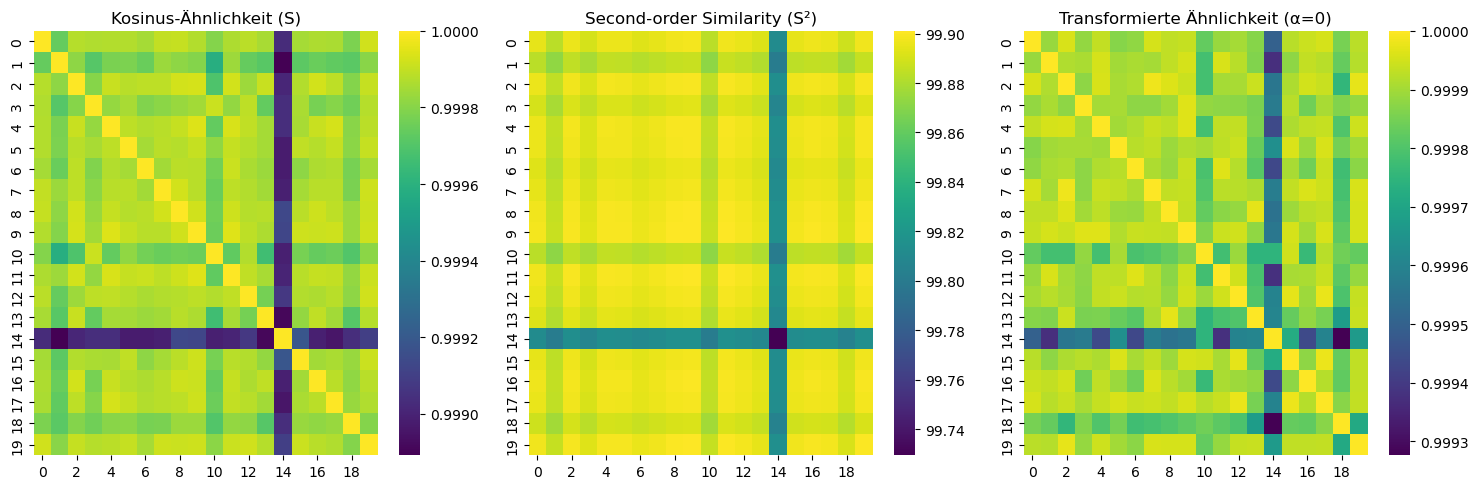

In [37]:
# 6.1 Heatmap der Ähnlichkeitsmatrizen

subset_size = min(20, len(X_normalized))  # Nur ein Teil für bessere Übersicht

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(S[:subset_size, :subset_size], cmap='viridis')
plt.title('Kosinus-Ähnlichkeit (S)')

plt.subplot(1, 3, 2)
sns.heatmap(S2[:subset_size, :subset_size], cmap='viridis')
plt.title('Second-order Similarity (S²)')

plt.subplot(1, 3, 3)
sns.heatmap(S_alpha0[:subset_size, :subset_size], cmap='viridis')
plt.title('Transformierte Ähnlichkeit (α=0)')

plt.tight_layout()
plt.show()


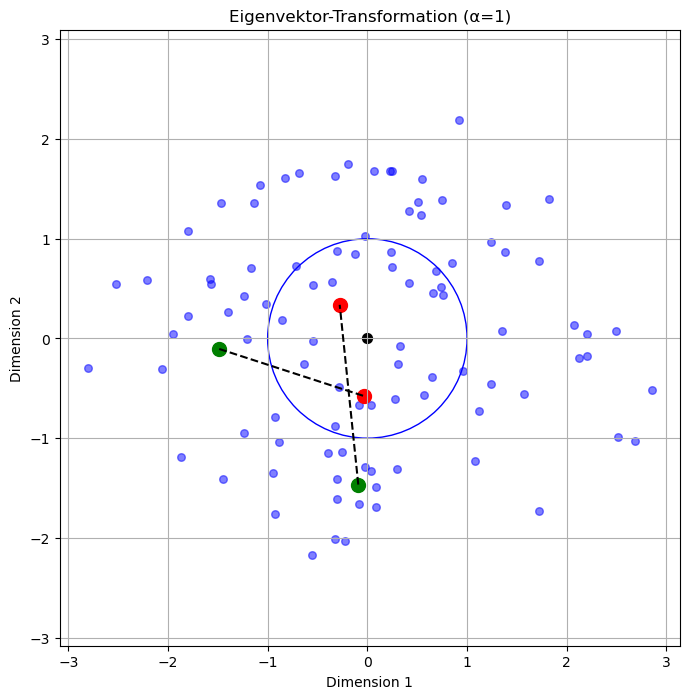

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Angenommen, Sie haben bereits X, Q und Lambda definiert
# Hier erstellen wir Dummy-Daten, falls diese fehlen
np.random.seed(42)
X = np.random.rand(100, 5)  # 100 Datenpunkte, 5 Dimensionen
Q = np.random.rand(5, 5)
Lambda = np.diag(np.random.rand(5))

# Normalisieren der Daten
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

def create_transformation(Q, Lambda, alpha):
    """Erstellt die Transformationsmatrix basierend auf den Eigenvektoren,
    Eigenwerten und dem Skalierungsfaktor alpha."""
    eigenvalues_alpha = np.power(np.diag(Lambda), alpha)
    Lambda_alpha = np.diag(eigenvalues_alpha)
    W_alpha = np.dot(Q, np.dot(Lambda_alpha, Q.T))
    return W_alpha

plt.figure(figsize=(8, 8))

# PCA auf normalisierte Vektoren (auf 100 Punkte begrenzen)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)  # Verwenden Sie alle 100 Punkte für das PCA-Fitting

# Zwei Referenzpunkte (Indizes müssen innerhalb der Daten liegen)
point1_index = 0
point2_index = 1
point1 = X_pca[point1_index]
point2 = X_pca[point2_index]

# Originalpunkte (verwenden Sie die PCA-reduzierten Daten)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c='blue', s=30)
plt.scatter(point1[0], point1[1], c='green', s=100)
plt.scatter(point2[0], point2[1], c='green', s=100)

# Transformation mit α=1
alpha = 1.0
W_alpha = create_transformation(Q, Lambda, alpha)

# Anwenden der Transformation auf die normalisierten Daten
X_transformed = np.dot(X_normalized, W_alpha)

# Reduzieren der Dimensionen der transformierten Daten mit dem *bereits gefitteten* PCA-Objekt
X_transformed_pca = pca.transform(X_transformed)

# Transformierte Punkte (verwenden Sie die transformierten und PCA-reduzierten Daten)
transformed_point1 = X_transformed_pca[point1_index]
transformed_point2 = X_transformed_pca[point2_index]
plt.scatter(transformed_point1[0], transformed_point1[1], c='red', s=100)
plt.scatter(transformed_point2[0], transformed_point2[1], c='red', s=100)

# Verbindungslinien
plt.plot([point1[0], transformed_point1[0]], [point1[1], transformed_point1[1]], 'k--')
plt.plot([point2[0], transformed_point2[0]], [point2[1], transformed_point2[1]], 'k--')

# Einheitskreis und Ursprung
circle = plt.Circle((0, 0), 1, fill=False, color='blue')
plt.gca().add_patch(circle)
plt.scatter(0, 0, c='black', s=50)

plt.grid(True)
plt.axis('equal')
plt.title('Eigenvektor-Transformation (α=1)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [39]:
print("\nFinde semantisch ähnliche Texte mit verschiedenen α-Werten...")

# Wähle einen Referenztext
ref_idx = 0
ref_title = sample_df.iloc[valid_indices[ref_idx]]['title']
ref_artist = sample_df.iloc[valid_indices[ref_idx]]['artist']

print(f"Referenztext: '{ref_title}' von {ref_artist}")



Finde semantisch ähnliche Texte mit verschiedenen α-Werten...
Referenztext: 'Watch Roger Do His Thing' von Main Source


In [40]:
# Finde ähnliche Texte für verschiedene Alpha-Werte
for alpha in alpha_values:
    print(f"\nTop 5 ähnlichste Texte mit α={alpha}:")
    
    similarities = np.dot(transformed_vectors[alpha], transformed_vectors[alpha][ref_idx])
    most_similar = similarities.argsort()[::-1][1:6]  # Top 5 ohne den Referenztext selbst
    
    for i, idx in enumerate(most_similar):
        similar_title = sample_df.iloc[valid_indices[idx]]['title']
        similar_artist = sample_df.iloc[valid_indices[idx]]['artist']
        sim_score = similarities[idx]
        print(f"{i+1}. '{similar_title}' von {similar_artist} (Ähnlichkeit: {sim_score:.4f})")



Top 5 ähnlichste Texte mit α=0.0:
1. 'Amen' von Lil Wayne (Ähnlichkeit: 1.0000)
2. 'If You Was Me' von Green Eyez (Ähnlichkeit: 1.0000)
3. 'Time to Rock' von Army of the Pharaohs (Ähnlichkeit: 1.0000)
4. 'Get High to This' von Lil Wyte (Ähnlichkeit: 1.0000)
5. 'Growin Old' von Pigeon John (Ähnlichkeit: 1.0000)

Top 5 ähnlichste Texte mit α=0.5:
1. 'If You Was Me' von Green Eyez (Ähnlichkeit: 1.0000)
2. 'Amen' von Lil Wayne (Ähnlichkeit: 1.0000)
3. 'Headaches and Woes' von Aceyalone (Ähnlichkeit: 1.0000)
4. 'Paper Chase' von JAY-Z (Ähnlichkeit: 1.0000)
5. 'Give It Up For Compton' von Dresta (Ähnlichkeit: 1.0000)

Top 5 ähnlichste Texte mit α=1.0:
1. 'Paper Chase' von JAY-Z (Ähnlichkeit: 1.0000)
2. 'If You Was Me' von Green Eyez (Ähnlichkeit: 1.0000)
3. 'Headaches and Woes' von Aceyalone (Ähnlichkeit: 1.0000)
4. 'Magnitude' von Moka Only (Ähnlichkeit: 1.0000)
5. 'Food for Thought' von Joell Ortiz (Ähnlichkeit: 1.0000)

Top 5 ähnlichste Texte mit α=2.0:
1. 'Road to Success' von Tunnel Ra

In [41]:
# Berechne Differenzmatrix
diff_matrix = np.abs(S_alpha0 - S_alpha1)

# Suche nach Top-n Paaren mit größter Differenz
n_pairs = 5
flat_indices = np.argsort(diff_matrix.flatten())[::-1]
divergent_pairs = []

for idx in flat_indices:
    i, j = idx // diff_matrix.shape[1], idx % diff_matrix.shape[1]
    if i != j and (j, i) not in divergent_pairs:
        divergent_pairs.append((i, j))
        if len(divergent_pairs) >= n_pairs:
            break


In [42]:
print(f"\nTop {n_pairs} Textpaare mit divergenter Information (größte Differenz zwischen α=0 und α=1):")

for i, (idx1, idx2) in enumerate(divergent_pairs):
    if idx1 < len(valid_indices) and idx2 < len(valid_indices):
        text1_title = sample_df.iloc[valid_indices[idx1]]['title']
        text1_artist = sample_df.iloc[valid_indices[idx1]]['artist']
        text2_title = sample_df.iloc[valid_indices[idx2]]['title']
        text2_artist = sample_df.iloc[valid_indices[idx2]]['artist']
        
        sim_alpha0 = S_alpha0[idx1, idx2]
        sim_alpha1 = S_alpha1[idx1, idx2]
        diff = diff_matrix[idx1, idx2]
        
        print(f"{i+1}. '{text1_title}' (von {text1_artist}) <-> '{text2_title}' (von {text2_artist})")
        print(f"   Ähnlichkeit (α=0): {sim_alpha0:.4f}")
        print(f"   Ähnlichkeit (α=1): {sim_alpha1:.4f}")
        print(f"   Differenz: {diff:.4f}\n")



Top 5 Textpaare mit divergenter Information (größte Differenz zwischen α=0 und α=1):
1. 'Loco Por Vida' (von Spanish F.L.Y.) <-> 'Rockit' (von Gorillaz)
   Ähnlichkeit (α=0): 0.9558
   Ähnlichkeit (α=1): 1.0000
   Differenz: 0.0442

2. 'Rockit' (von Gorillaz) <-> 'Live It Up' (von Kid Ink)
   Ähnlichkeit (α=0): 0.9570
   Ähnlichkeit (α=1): 1.0000
   Differenz: 0.0430

3. 'Knock It Out' (von Yung Joc) <-> 'Rockit' (von Gorillaz)
   Ähnlichkeit (α=0): 0.9578
   Ähnlichkeit (α=1): 1.0000
   Differenz: 0.0422

4. 'Rockit' (von Gorillaz) <-> 'Lazy Afternoon' (von The Roots)
   Ähnlichkeit (α=0): 0.9585
   Ähnlichkeit (α=1): 1.0000
   Differenz: 0.0415

5. 'Tomorrow' (von Rocko) <-> 'Rockit' (von Gorillaz)
   Ähnlichkeit (α=0): 0.9597
   Ähnlichkeit (α=1): 1.0000
   Differenz: 0.0403

